In [1]:
from valurap import printer, commands
import imp
imp.reload(commands)
imp.reload(printer)

from math import sqrt
from valurap.asg import Asg, ProfileSegment, PathSegment

%matplotlib inline
import pandas as pd

class ApgState(object):
    def __init__(self):
        self.x = 0
        self.v = 0
        self.a = 0
        self.j = 0
        self.jj = 0
        self.target_v = 0
        self.target_v_set = False
        
    def load(self, seg):
        if seg.x is not None:
            self.x = seg.x * 2**32
        if seg.v is not None:
            self.v = seg.v
        if seg.a is not None:
            self.a = seg.a
        if seg.j is not None:
            self.j = seg.j
        if seg.jj is not None:
            self.jj = seg.jj
        if seg.target_v is not None:
            self.target_v = seg.target_v
            self.target_v_set = True
        else:
            self.target_v_set = False
            
    def step(self):
        next_x = self.x + self.v * 50000
        next_v = int(self.v + (self.a / 65536))
        next_a = self.a + self.j
        next_j = self.j + self.jj
        next_jj = self.jj
        if self.target_v_set:
            if self.v == self.target_v:
                next_jj = 0
                next_j = 0
                next_a = 0
                next_v = self.target_v
            elif ((self.v < self.target_v and next_v > self.target_v) or 
                  (self.v > self.target_v and next_v < self.target_v)):
                next_jj = 0
                next_j = 0
                next_v = self.target_v
                next_a = (self.target_v - self.v) * 65536
             
        #effective_v = (self.v + next_v) / 2
        effective_v = next_v

        self.x = next_x
        self.v = next_v
        self.a = next_a
        self.j = next_j
        self.jj = next_jj
        
    
def emulate(profile, verbose=False):
    apg_states = {
        "X": ApgState(),
        "Y": ApgState(),
        "Z": ApgState()
    }
    ts = 0
    steps = {}
    for dt, segs in profile:
        print(dt)
        ts_start = ts
        ts += dt
        for seg in segs:
            print("  ",seg)
            state = apg_states[seg.apg.name]
            state.load(seg)
            prefix = seg.apg.name + "_"
            
            if not verbose:
                print("    {:6d} {:10.3f} {:10.1f} {:10.1f}".format(ts_start, state.x / 2.0**32, state.v, state.a))
                print("                 ...")

            last_v = None
            first_v = 0
            for i in range(dt):
                step_data = steps.setdefault(ts_start + i, {'ts': ts_start + i})
                step_data[prefix + "jj"] = state.jj
                step_data[prefix + "j"] = state.j
                step_data[prefix + "a"] = state.a
                step_data[prefix + "v"] = state.v/65536
                step_data[prefix + "x"] = state.x/2**32

                if state.v != last_v:
                    if verbose:
                        if first_v > 0:
                            if first_v > 1:
                                print("        ... {} ...".format(first_v - 1))
                            print("    {:6d} {:10.3f} {:10.1f} {:10.1f}".format(ts_start + i - 1, prev_x / 2.0**32, prev_v, prev_a))
                        print("    {:6d} {:10.3f} {:10.1f} {:10.1f}".format(ts_start + i, state.x / 2.0**32, state.v, state.a))
                    last_v = state.v
                    first_v = 0
                else:
                    if not verbose and first_v == 0:
                        print("    {:6d} {:10.3f} {:10.1f} {:10.1f}".format(ts_start + i - 1, prev_x / 2.0**32, prev_v, prev_a))

                    first_v += 1
                    
                prev_x = state.x
                prev_v = state.v
                prev_a = state.a
                state.step()

            if verbose:
                if first_v != 0:
                    if first_v > 1:
                        print("           ... {} ...".format(first_v - 1))
                    print("    {:6d} {:10.3f} {:10.1f} {:10.1f}".format(ts_start + i, state.x / 2.0**32, state.v, state.a))
            else:
                if first_v > 1:
                    print("                 ...")

                print("    {:6d} {:10.3f} {:10.1f} {:10.1f}".format(ts_start + i, state.x / 2.0**32, state.v, state.a))
            

    steps = [a[1] for a in sorted(steps.items())]
    steps = pd.DataFrame(steps)
    return steps
                
p = printer.Valurap()
    
p.axes["X1"].apg = p.apgs["X"]
p.axes["X2"].apg = p.apgs["Y"]
p.axes["Y"].apg = p.apgs["Z"]

428
   <ProfileSegment apg=Z v=0 a=0 j=9750212 jj=-68423 target_v=2006994>
         0      0.000        0.0        0.0
                 ...
         0      0.000        0.0        0.0
       267   2916.380  2006994.0 111017984.0
                 ...
       427   6678.062  2006994.0        0.0
285
   <ProfileSegment apg=Z a=0 j=-9750212 jj=68423 target_v=0>
       428   6678.062  2006994.0        0.0
                 ...
       428   6678.062  2006994.0        0.0
       695   9999.589        0.0 -93650944.0
                 ...
       712   9999.589        0.0        0.0
10
   <ProfileSegment apg=Z v=0 a=0 j=0 jj=0>
       713   9999.589        0.0        0.0
                 ...
       713   9999.589        0.0        0.0
                 ...
       722   9999.589        0.0        0.0


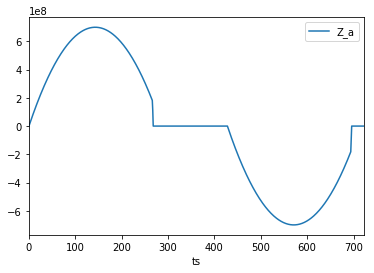

In [2]:
pr = p.plan_move(Y=10000)

steps = emulate(pr, False)
steps.plot(x = "ts", y = ["Z_a"])

In [ ]:
from ortools.sat.python import cp_model
import time

def solve_model(in_v, target_plato_v, target_out_v, target_x, accel_t, 
                plato_t, decel_t, max_a = 20000, min_delta_v=100):
    model = cp_model.CpModel()
    
    vtoa_k = 65536
    xtov_k = 2**32 / 50000
    xtoa_k = vtoa_k * xtov_k

    # optimized profile parameters
    accel_j = model.NewIntVar(-2**29, 2**29, 'accel_j')
    accel_jj = model.NewIntVar(-2**29, 2**29, 'accel_jj')

    plato_v6 = model.NewIntVar(-2**50, 2**50, 'plato_v6')

    decel_j = model.NewIntVar(-2**29, 2**29, 'decel_j')
    decel_jj = model.NewIntVar(-2**29, 2**29, 'decel_jj')

    # optimization targets
    #  speed at the end of accel
    accel_v6 = model.NewIntVar(-2**55, 2**55, 'accel_v6')
    #  speed at the end of decel
    decel_v6 = model.NewIntVar(-2**55, 2**55, 'decel_v6')
    #  total X
    total_x24 = model.NewIntVar(-2**55, 2**55, 'total_x24')

    # errors
    dx24 = model.NewIntVar(0, int(xtoa_k / 2 * 24), 'dx24') # X error - +- 0.5 step
    
    # Speed errors +- 5% or 1.4mm/s
    plato_dv6 = model.NewIntVar(0, int(max(target_plato_v * 0.05, min_delta_v) * vtoa_k * 6), 'plato_dv6') # plato speed
    accel_dv6 = model.NewIntVar(0, int(max(target_plato_v * 0.05, min_delta_v) * vtoa_k * 6), 'accel_dv6') # plato speed
    decel_dv6 = model.NewIntVar(0, int(max(target_out_v * 0.05, min_delta_v) * vtoa_k * 6), 'decel_dv6') # exit speed

    accel_dj = model.NewIntVar(0, 10, 'accel_dj') # residual J
    decel_dj = model.NewIntVar(0, 10, 'decel_dj') # residual J

    # x = v*t + a*t/2 + j*t*(t-1)*(t-2)/6 + jj*t*(t-1)*(t-2)*(t-3)/24
    # working with x24 multiply

    # end of accel X
    accel_x24 = model.NewIntVar(-2**50, 2**50, 'accel_x24')

    # end of plato X
    plato_x24 = model.NewIntVar(-2**50, 2**50, 'plato_x24')

    # end of decel X
    # adding x24 = x * 24 and rounding error x24_delta to keep it integer
    decel_x24 = model.NewIntVar(-2**50, 2**50, 'decel_x24')

    # X accel discrete integral
    model.Add(accel_x24 == 
              24 * in_v * vtoa_k * accel_t
              + accel_jj * (accel_t**4) 
              - 6 * accel_jj * (accel_t**3) + 4 * accel_j * (accel_t**3) 
              + 11 * accel_jj * (accel_t**2) - 12 * accel_j * (accel_t**2)
              - 6 * accel_jj * accel_t + 8 * accel_j * accel_t
             )

    # V accel discrete integral
    model.Add(accel_v6 == 
              6 * in_v * vtoa_k
              + accel_jj * (accel_t**3) 
              - 3 * accel_jj * (accel_t**2) + 3 * accel_j * (accel_t**2) 
              + 2 * accel_jj * accel_t - 3 * accel_j * accel_t
             )

    # X plato discrete integral
    model.Add(plato_x24 == 4 * plato_v6 * plato_t)
        
    # X decel discrete integral
    model.Add(decel_x24 == 
              4 * plato_v6 * decel_t 
              + decel_jj * (decel_t**4) 
              - 6 * decel_jj * (decel_t**3) + 4 * decel_j * (decel_t**3) 
              + 11*decel_jj * (decel_t**2) - 12*decel_j * (decel_t**2) 
              - 6 * decel_jj * decel_t + 8 * decel_j * decel_t
             )
    # V decel discrete integral
    model.Add(decel_v6 == 
              plato_v6 
              + decel_jj * (decel_t**3) 
              - 3 * decel_jj * (decel_t**2) + 3 * decel_j * (decel_t**2) 
              + 2*decel_jj * decel_t - 3*decel_j * decel_t)

    model.Add(total_x24 == accel_x24 + plato_x24 + decel_x24)
    
    # target X
    model.Add(-dx24 < total_x24 - int(target_x * xtoa_k * 24))
    model.Add(total_x24 - int(target_x * xtoa_k * 24) < dx24)

    if 1:
        # target V
        model.Add(-plato_dv6 < (plato_v6 - int(target_plato_v * vtoa_k * 6)))
        model.Add((plato_v6 - int(target_plato_v * vtoa_k * 6)) < plato_dv6)
        #model.Add(accel_v6 == plato_v6)
        model.Add(-accel_dv6 < (accel_v6 - int(target_plato_v * vtoa_k * 6)))
        model.Add((accel_v6 - int(target_plato_v * vtoa_k * 6)) < accel_dv6)

    if in_v < target_plato_v:
        model.Add(accel_j > 0)
        model.Add(accel_jj < 0)
    else:
        model.Add(accel_j < 0)
        model.Add(accel_jj > 0)
        
    if target_plato_v > target_out_v:
        model.Add(decel_j < 0)
        model.Add(decel_jj > 0)
    else:
        model.Add(decel_j > 0)
        model.Add(decel_jj < 0)
        
    model.Add(-decel_dv6 < decel_v6 - int(target_out_v * vtoa_k * 6))
    model.Add(decel_v6 - int(target_out_v * vtoa_k * 6) < decel_dv6)

    # Accel limit
    model.Add(accel_j * accel_t < max_a * vtoa_k * 2)
    model.Add(-max_a * vtoa_k * 2 < accel_j * accel_t)
    model.Add(decel_j * decel_t < max_a * vtoa_k * 2)
    model.Add(-max_a * vtoa_k * 2 < decel_j * decel_t)

    # accel to 0 at the end of move
    model.Add(-accel_dj < accel_jj * accel_t + 2 * accel_j)
    model.Add(accel_jj * accel_t + 2 * accel_j < accel_dj)
    model.Add(-accel_dj < decel_jj * decel_t + 2 * decel_j)
    model.Add(decel_jj * decel_t + 2 * decel_j < decel_dj)

    if 1:
        model.Minimize(plato_dv6)
        model.Minimize(decel_dv6)

        model.Minimize(dx24)
        model.Minimize(accel_dj)
        model.Minimize(decel_dj)

    print(dir(model._CpModel__model))
    
    valid = model.Validate()
    print(type(valid))
    print(valid)
    for i in range(20):
        try:
            print(i, model.VarIndexToVarProto(i))
        except IndexError:
            break
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    print(status)
    if status == cp_model.MODEL_INVALID:
        return None
    
    if status == 3:
        return None
    
    if True or status == cp_model.FEASIBLE:
        print('accel_t = %i' % solver.Value(accel_t))
        print('accel_jj = %i' % solver.Value(accel_jj))
        print('accel_j = %i' % solver.Value(accel_j))
        print('accel_dj = %i' % solver.Value(accel_dj))
        print('accel_v = %.2f' % (solver.Value(accel_v6)/6/vtoa_k))
        print('accel_x = %.2f' % (solver.Value(accel_x24)/24/xtoa_k))
        print()
        print('plato_v = %.2f' % (solver.Value(plato_v6)/6/vtoa_k))
        print('plato_v6 = %.2f' % (solver.Value(plato_v6)))
        print('plato_dv = %.2f' % (solver.Value(plato_dv6)/6/vtoa_k))
        print('plato_x = %.2f' % (solver.Value(plato_x24)/24/xtoa_k))
        print()
        print('decel_t = %i' % solver.Value(decel_t))
        print('decel_jj = %i' % solver.Value(decel_jj))
        print('decel_j = %i' % solver.Value(decel_j))
        print('decel_dj = %i' % solver.Value(decel_dj))
        print('decel_v = %.2f' % (solver.Value(decel_v6)/6/vtoa_k))
        print('decel_dv = %.2f' % (solver.Value(decel_dv6)/6/vtoa_k))
        print('decel_x = %.2f' % (solver.Value(decel_x24)/24/xtoa_k))
        print()
        print('total_x = %.2f' % (solver.Value(total_x24)/24/xtoa_k))

        
    return {
        "accel_j": solver.Value(accel_j),
        "accel_jj": solver.Value(accel_jj),
        "plato_v": solver.Value(plato_v6)/6/vtoa_k,
        "decel_j": solver.Value(decel_j),
        "decel_jj": solver.Value(decel_jj),
        "accel_x": (solver.Value(accel_x24)/24/xtoa_k),
        "plato_x": (solver.Value(plato_x24)/24/xtoa_k),
        "decel_x": (solver.Value(decel_x24)/24/xtoa_k),
    }

In [ ]:
t = time.time()
accel_t = 200
plato_t = 658
decel_t = 200
solution = solve_model(in_v=0, target_plato_v=1000000, target_out_v=0, target_x=10200, accel_t=accel_t, plato_t=plato_t, decel_t=decel_t, max_a = 200000, min_delta_v=10)

t2 = time.time()
print("solving time", (t2-t)*1000)

if solution:
    apg = p.apgs["X"]

    pr = [
        [accel_t, [
            ProfileSegment(apg=apg, j=solution["accel_j"], jj=solution["accel_jj"])
        ]],
        [plato_t, [
            ProfileSegment(apg=apg, j=0, jj=0,a=0, v = solution["plato_v"])
        ]],
        [decel_t, [
            ProfileSegment(apg=apg, j=solution["decel_j"], jj=solution["decel_jj"],
                                              target_v = 0)
        ]],
    ]
    steps = emulate(pr, False)
    steps.plot(x = "ts", y = ["X_a"])
    steps.plot(x = "ts", y = ["X_v"])
    steps.plot(x = "ts", y = ["X_x"])

In [ ]:
target_x = 10000
pr = p.plan_move(Y=target_x, min_dt=200)
print(pr)

a_plus_p = pr[0][0]
decel_t = pr[1][0]
plato_t = a_plus_p - decel_t
accel_t = decel_t
target_v = pr[0][1][0].target_v

t = time.time()
solution = solve_model(in_v=0, target_plato_v=target_v, target_out_v=0, 
                       target_x=target_x, accel_t=accel_t, plato_t=plato_t, 
                       decel_t=decel_t, max_a = 200000)
t2 = time.time()

print("solving time", (t2-t)*1000)

if solution:
    apg = p.apgs["X"]

    pr = [
        [accel_t, [
            ProfileSegment(apg=apg, j=solution["accel_j"], jj=solution["accel_jj"])
        ]],
        [plato_t, [
            ProfileSegment(apg=apg, j=0, jj=0,a=0, v = solution["plato_v"])
        ]],
        [decel_t, [
            ProfileSegment(apg=apg, j=solution["decel_j"], jj=solution["decel_jj"],
                                              target_v = 0)
        ]],
    ]
    steps = emulate(pr, False)
    steps = pd.DataFrame(steps)
    steps.plot(x = "ts", y = ["X_a"])
    steps.plot(x = "ts", y = ["X_v"])
    steps.plot(x = "ts", y = ["X_x"])

In [ ]:
target_x = 10000
target_y = -3000

pr = p.plan_move(X1=target_x, Y=target_y, min_dt=200)
print(pr)

a_plus_p = pr[0][0]
decel_t = pr[1][0]
plato_t = a_plus_p - decel_t
accel_t = decel_t
target_vx = pr[0][1][0].target_v
target_vy = pr[0][1][1].target_v

t = time.time()
solution_x = solve_model(in_v=0, target_plato_v=target_vx, target_out_v=0, 
                       target_x=target_x, accel_t=accel_t, plato_t=plato_t, 
                       decel_t=decel_t, max_a = 200000)
solution_y = solve_model(in_v=0, target_plato_v=target_vy, target_out_v=0, 
                       target_x=target_y, accel_t=accel_t, plato_t=plato_t, 
                       decel_t=decel_t, max_a = 200000)
t2 = time.time()

print("solving time", (t2-t)*1000)

if solution:
    apg_x = p.apgs["X"]
    apg_y = p.apgs["Y"]


    pr = [
        [accel_t, [
            ProfileSegment(apg=apg_x, j=solution_x["accel_j"], jj=solution_x["accel_jj"]),
            ProfileSegment(apg=apg_y, j=solution_y["accel_j"], jj=solution_y["accel_jj"])
        ]],
        [plato_t, [
            ProfileSegment(apg=apg_x, j=0, jj=0,a=0, v = solution_x["plato_v"]),
            ProfileSegment(apg=apg_y, j=0, jj=0,a=0, v = solution_y["plato_v"])
        ]],
        [decel_t, [
            ProfileSegment(apg=apg_x, j=solution_x["decel_j"], jj=solution_x["decel_jj"],
                                              target_v = 0),
            ProfileSegment(apg=apg_y, j=solution_y["decel_j"], jj=solution_y["decel_jj"],
                                              target_v = 0)
        ]],
    ]
    steps = emulate(pr, False)
    steps = pd.DataFrame(steps)
    steps.plot(x = "ts", y = ["X_a", "Y_a"])
    steps.plot(x = "ts", y = ["X_v", "Y_v"])
    steps.plot(x = "ts", y = ["X_x", "Y_x"])
    steps.plot(x = "X_x", y = "Y_x")



In [81]:
from math import sqrt
from numpy import array, absolute, isnan
from numpy.linalg import norm

from valurap import printer, commands
from valurap.asg import Asg, ProfileSegment, PathSegment


def solve_model_simple(in_v, target_plato_v, target_out_v, target_x, accel_t, 
                plato_t, decel_t, max_a = 20000, min_delta_v=100):
    
    vtoa_k = 65536
    xtov_k = 2**32 / 50000
    xtoa_k = vtoa_k * xtov_k

    def ir(x):
        return int(round(x))
    
    def int_x(t, v, a, j, jj):
        return ir(v * t + a*t*(t-1)/2 + j*t*(t-1)*(t-2)/6 + jj*t*(t-1)*(t-2)*(t-3)/24)

    def int_v(t, v, a, j, jj):
        return ir(v + a * t + j*t*(t-1)/2 + jj*t*(t-1)*(t-2)/6)


    accel_a = (target_plato_v - in_v) / accel_t * vtoa_k * 1.5
    accel_j = accel_a / accel_t * 2 * 2
    accel_jj = -accel_j / accel_t * 2
    
    print("accel_a:", accel_a)
    print("accel_j:", accel_j)
    print("accel_jj:", accel_jj)
    
    int_accel_jj = ir(accel_jj)
    int_accel_j = ir(-int_accel_jj * accel_t / 2)
    print("int_accel_j:", int_accel_j)
    print("int_accel_jj:", int_accel_jj)
    
    int_accel_x = int_x(accel_t, in_v * vtoa_k, 0, int_accel_j, int_accel_jj)
    int_accel_v = int_v(accel_t, in_v * vtoa_k, 0, int_accel_j, int_accel_jj)
    

    decel_a = (target_out_v - target_plato_v) / decel_t * vtoa_k * 1.5
    decel_j = decel_a / decel_t * 2 * 2
    decel_jj = -decel_j / decel_t * 2
    
    int_decel_jj = ir(decel_jj)
    int_decel_j = ir(-int_decel_jj * decel_t / 2)
    
    int_decel_x = int_x(decel_t, target_plato_v * vtoa_k, 0, int_decel_j, int_decel_jj)
    int_decel_v = int_v(decel_t, target_plato_v * vtoa_k, 0, int_decel_j, int_decel_jj)


    plato_x = target_x * xtoa_k - int_accel_x - int_decel_x
    plato_v = plato_x / plato_t
    
    int_plato_v = ir(plato_v)
    int_plato_x = int_x(plato_t, int_plato_v, 0, 0, 0)
    
    return {
        "accel_j": int_accel_j,
        "accel_jj": int_accel_jj,
        "plato_v": int_plato_v/vtoa_k,
        "decel_j": int_decel_j,
        "decel_jj": int_decel_jj,
        "accel_x": int_accel_x/xtoa_k,
        "plato_x": int_plato_x/xtoa_k,
        "decel_x": int_decel_x/xtoa_k,
    }


p = printer.Valurap()
apg_x = p.apgs["X"]
apg_y = p.apgs["Y"]

path_deltas = [
    [100.0, 100.0, 200.0],
    [100.0, -100.0, 100.0],
    [100.0, -200.0, 200.0],
    [-150.0, -50.0, 150.0],
    [-150.0, 150.0, 150.0],
    [10.0, -200.0, 200.0],
    [50.0, 200.0, 200.0],
    [-60.0, 100.0, 200.0],
] * 3

path_deltas = [
    [120.0, -0.0, 250.0],
    [-0.0, 120.0, 250.0],
    [-120.0, 50.0, 250.0],
    [50.0, -120.0, 250.0],
    [-50.0, -50.0, 150.0],
] * 3

path_deltas = [
    [10, 250.0, 200.0],
    [1, 25.0, 50.0],
    [2, 0.0, 30.0],
    [-1, -25.0, 50.0],
    [-10, -250.0,  200.0],
    [-1, -25.0, 50.0],
    [-2, 0.0, 30.0],
    [1, 25.0, 50.0],
] * 10


path = []
x = 0
y = 0
for dx, dy, speed in path_deltas:
    x += dx
    y += dy
    path.append([x, y, speed])
    
print(path)

max_a = array([3000.0, 3000.0])

pr = []
pr_opt = []

in_x = array([0,0])
in_target = array([0,0])
in_v = array([0,0])
in_avail = array([0,0])

for i, seg in enumerate(path):
    target_x, target_y, target_v = seg
    
    cur_target = array([target_x, target_y])
    
    cur_d = cur_target - in_target
    assert(norm(cur_d) > 0)
    assert(target_v > 0)
    
    if i == len(path) - 1:
        out_v = array([0, 0])
        out_avail = array([0, 0])
    else:
        next_x, next_y, next_v = path[i+1]
        next_target = array([next_x, next_y])
        next_d = next_target - cur_target
        assert(norm(next_d) > 0)
        
        out_v = next_v * next_d / norm(next_d)
        out_avail = next_d / 2

    cur_avail = cur_d
    plato_v = target_v * cur_d / norm(cur_d)
    
    print("speeds:", in_v, plato_v, out_v)
    print("avails:", in_avail, cur_avail, out_avail)

    # Enter
    enter_delta_v = plato_v - in_v
    print("enter_delta_v:", enter_delta_v)
    
    enter_time = max(list(absolute(enter_delta_v) / max_a))
    print("enter_time:", enter_time)
    
    enter_a = enter_delta_v / enter_time
    print("enter_a:", enter_a)
    enter_speed_filter = absolute(enter_delta_v) > 0.1

    enter_delta_x = in_v * enter_time + enter_a * enter_time**2 / 2
    print("enter_delta_x:", enter_delta_x)
    
    enter_t_first = (enter_time * plato_v[enter_speed_filter] - enter_delta_x[enter_speed_filter]) / enter_delta_v[enter_speed_filter]
    enter_t_second = enter_time - enter_t_first
    print("enter_t_first:", enter_t_first)
    print("enter_t_second:", enter_t_second)
    assert((enter_t_first >= 0).all())
    assert((enter_t_second >= 0).all())
    
    enter_need_first = in_v[enter_speed_filter] * enter_t_first
    enter_need_second = plato_v[enter_speed_filter] * enter_t_second
    print("enter_need_first:", enter_need_first)
    print("enter_need_second:", enter_need_second)
    enter_need_first_filter = absolute(enter_need_first) > 0.01
    enter_need_second_filter = absolute(enter_need_second) > 0.01
    assert((in_avail[enter_speed_filter][enter_need_first_filter]/enter_need_first[enter_need_first_filter] > 1.0).all())
    assert((cur_avail[enter_speed_filter][enter_need_second_filter]/enter_need_second[enter_need_second_filter] > 2.0).all())
    cur_avail[enter_speed_filter] = cur_avail[enter_speed_filter] - enter_need_second
        
    # Exit
    exit_delta_v = out_v - plato_v
    print("exit_delta_v:", exit_delta_v)

    exit_time = max(list(absolute(exit_delta_v) / max_a))
    print("exit_time:", exit_time)

    exit_a = exit_delta_v / exit_time
    print("exit_a:", exit_a)
    exit_speed_filter = absolute(exit_delta_v) > 0.1

    exit_delta_x = plato_v * exit_time + exit_a * exit_time**2 / 2
    print("exit_delta_x:", exit_delta_x)

    exit_t_first = (exit_time * out_v[exit_speed_filter] - exit_delta_x[exit_speed_filter]) / exit_delta_v[exit_speed_filter]
    exit_t_second = exit_time - exit_t_first
    
    print("exit_t_first:", exit_t_first)
    print("exit_t_second:", exit_t_second)
    assert((exit_t_first >= 0).all())
    assert((exit_t_second >= 0).all())

    exit_need_first = plato_v[exit_speed_filter] * exit_t_first 
    exit_need_second = out_v[exit_speed_filter] * exit_t_second
    print("exit_need_first:", exit_need_first)
    print("exit_need_second:", exit_need_second)
    exit_need_first_filter = absolute(exit_need_first) > 0.01
    exit_need_second_filter = absolute(exit_need_second) > 0.01
    print("exit_first_filter:", exit_first_filter)
    print("exit_second_filter:", exit_second_filter)
    assert(((cur_avail[exit_speed_filter][exit_need_first_filter]/exit_need_first[exit_need_first_filter]) > 1.0).all())
    assert(((out_avail[exit_speed_filter][exit_need_second_filter]/exit_need_second[exit_need_second_filter]) > 2.0).all())

    
    if norm(in_v) > 0:
        # remaining path from first step from end of last accel to start of new accel
        # performing with constant speed
        #  remaining path
        prev_plato = (in_target - in_x)
        prev_plato[enter_speed_filter] -= enter_need_first
        #  required time in ms
        prev_t = int(round(1000 * norm(prev_plato) / norm(in_v)))

        #  recalcalcalculated speed (possible with small jerk)
        prev_v = prev_plato / (prev_t / 1000)
        prev_v_x = int(round(prev_v[0] * 80 * 2**32 / 50000000))
        prev_v_y = int(round(prev_v[1] * 80 * 2**32 / 50000000))

        print("prev_plato_jerk:", in_v - prev_v)
        #new accel start point
        accel_start = in_x + array([prev_v_x, prev_v_y]) * prev_t / (80 * 2**32 / 50000000) / 1000
    else:
        prev_t = 0
        prev_v = in_v
        accel_start = in_x
    
    
    # new decel finish_point
    print("cur_target:", cur_target)
    decel_end = cur_target 
    decel_end[exit_speed_filter] += exit_need_second
    print("decel_end:", decel_end)
    
    plato_t = int(round(1000 * (norm(cur_d)/norm(plato_v) - enter_t_second[0] - exit_t_first[0] )))
    accel_t = int(round(1000 * (enter_t_first[0] + enter_t_second[0])))
    decel_t = int(round(1000 * (exit_t_first[0] + exit_t_second[0])))

    print("accel_start:", accel_start)
    target_x = decel_end - accel_start
    print("target_x:", target_x)
    
    args_x = dict(
        in_v=int(round(prev_v[0] * 80 * 2**32 / 50000000)),
        target_plato_v=int(round(plato_v[0] * 80 * 2**32 / 50000000)),
        target_out_v=int(round(out_v[0] * 80 * 2**32 / 50000000)),
        target_x=int(round(target_x[0] * 80)),
        accel_t=accel_t,
        plato_t=plato_t, 
        decel_t=decel_t,
        max_a = 200000,
        min_delta_v=500
    )
    n = 10
    print("args_x:", args_x)
    while n > 0:
        solution_x = solve_model_simple(**args_x)
        if solution_x:
            break
        args_x["min_delta_v"] *= 5
        n -= 1
    assert(solution_x)

    args_y = dict(
        in_v=int(round(prev_v[1] * 80 * 2**32 / 50000000)),
        target_plato_v=int(round(plato_v[1] * 80 * 2**32 / 50000000)),
        target_out_v=int(round(out_v[1] * 80 * 2**32 / 50000000)),
        target_x=int(round(target_x[1] * 80)),
        accel_t=accel_t,
        plato_t=plato_t, 
        decel_t=decel_t,
        max_a = 200000,
        min_delta_v=500
    )

    n = 10
    print("args_y:", args_y)
    while n > 0:
        solution_y = solve_model_simple(**args_y)
        if solution_y:
            break
        args_y["min_delta_v"] *= 5
        n -= 1

    assert(solution_x)
    print("sol_x:", solution_x)
    print("sol_y:", solution_y)
    if prev_t > 0:
        pr_opt += [
            [int(round(prev_t)), [
                ProfileSegment(apg=apg_x, v = prev_v_x),
                ProfileSegment(apg=apg_y, v = prev_v_y),
            ]]
        ]

    pr_opt += [
        [accel_t, [
            ProfileSegment(apg=apg_x, j=solution_x["accel_j"], jj=solution_x["accel_jj"]),
            ProfileSegment(apg=apg_y, j=solution_y["accel_j"], jj=solution_y["accel_jj"]),
        ]]
    ]
                       
    if i == len(path) - 1:
        pr_opt += [
            [plato_t, [
                ProfileSegment(apg=apg_x, v = solution_x["plato_v"]),
                ProfileSegment(apg=apg_y, v = solution_y["plato_v"]),
            ]],
            [decel_t, [
                ProfileSegment(apg=apg_x, j=solution_x["decel_j"], jj=solution_x["decel_jj"]),
                ProfileSegment(apg=apg_y, j=solution_y["decel_j"], jj=solution_y["decel_jj"]),
            ]],
            [5, [
                ProfileSegment(apg=apg_x, v=0),
                ProfileSegment(apg=apg_y, v=0),
            ]]

        ]

    print("i:", i)
    plato_v = array([solution_x["plato_v"], solution_y["plato_v"]])/(80.0 * 2**32 / 50000000)

    
    print()
    in_v = plato_v
    in_target = cur_target
    in_x = accel_start + array([solution_x["accel_x"], solution_y["accel_x"]]) / 80
    in_avail = in_target - in_x

%matplotlib notebook
    
import warnings
warnings.filterwarnings("error")

steps_opt = emulate(pr_opt, False)
steps_opt = pd.DataFrame(steps_opt)




[[10, 250.0, 200.0], [11, 275.0, 50.0], [13, 275.0, 30.0], [12, 250.0, 50.0], [2, 0.0, 200.0], [1, -25.0, 50.0], [-1, -25.0, 30.0], [0, 0.0, 50.0], [10, 250.0, 200.0], [11, 275.0, 50.0], [13, 275.0, 30.0], [12, 250.0, 50.0], [2, 0.0, 200.0], [1, -25.0, 50.0], [-1, -25.0, 30.0], [0, 0.0, 50.0], [10, 250.0, 200.0], [11, 275.0, 50.0], [13, 275.0, 30.0], [12, 250.0, 50.0], [2, 0.0, 200.0], [1, -25.0, 50.0], [-1, -25.0, 30.0], [0, 0.0, 50.0], [10, 250.0, 200.0], [11, 275.0, 50.0], [13, 275.0, 30.0], [12, 250.0, 50.0], [2, 0.0, 200.0], [1, -25.0, 50.0], [-1, -25.0, 30.0], [0, 0.0, 50.0], [10, 250.0, 200.0], [11, 275.0, 50.0], [13, 275.0, 30.0], [12, 250.0, 50.0], [2, 0.0, 200.0], [1, -25.0, 50.0], [-1, -25.0, 30.0], [0, 0.0, 50.0], [10, 250.0, 200.0], [11, 275.0, 50.0], [13, 275.0, 30.0], [12, 250.0, 50.0], [2, 0.0, 200.0], [1, -25.0, 50.0], [-1, -25.0, 30.0], [0, 0.0, 50.0], [10, 250.0, 200.0], [11, 275.0, 50.0], [13, 275.0, 30.0], [12, 250.0, 50.0], [2, 0.0, 200.0], [1, -25.0, 50.0], [-1, 

exit_time: 0.016653349312029823
exit_a: [ 1681.43942446 -3000.        ]
exit_delta_x: [0.26644028 0.41600106]
exit_t_first: [0.00832667 0.00832667]
exit_t_second: [0.00832667 0.00832667]
exit_need_first: [0.01664004 0.41600106]
exit_need_second: [0.24980024 0.        ]
exit_first_filter: [ True  True]
exit_second_filter: [False False]
prev_plato_jerk: [0.00031265 0.00865643]
cur_target: [ 11. 275.]
decel_end: [ 11.24980024 275.        ]
accel_start: [  9.8399736  246.00029456]
target_x: [ 1.40982664 28.99970544]
args_x: {'in_v': 56121, 'target_plato_v': 13733, 'target_out_v': 206158, 'target_x': 113, 'accel_t': 51, 'plato_t': 416, 'decel_t': 17, 'max_a': 200000, 'min_delta_v': 500}
accel_a: -81704116.70588236
accel_j: -6408166.016147636
accel_jj: 251300.628084221
int_accel_j: -6408176
int_accel_jj: 251301
args_y: {'in_v': 1403015, 'target_plato_v': 343323, 'target_out_v': 0, 'target_x': 2320, 'accel_t': 51, 'plato_t': 416, 'decel_t': 17, 'max_a': 200000, 'min_delta_v': 500}
accel_a: -2

enter_time: 0.05140470680317572
enter_a: [ 120.0010966 3000.       ]
enter_delta_x: [-0.26127535 -6.53184744]
enter_t_first: [0.02570235 0.02570235]
enter_t_second: [0.02570235 0.02570235]
enter_need_first: [-0.20991171 -5.24775663]
enter_need_second: [-0.05136363 -1.28409081]
exit_delta_v: [-28.00159808  49.96004794]
exit_time: 0.016653349312029823
exit_a: [-1681.43942446  3000.        ]
exit_delta_x: [-0.26644028 -0.41600106]
exit_t_first: [0.00832667 0.00832667]
exit_t_second: [0.00832667 0.00832667]
exit_need_first: [-0.01664004 -0.41600106]
exit_need_second: [-0.24980024  0.        ]
exit_first_filter: [ True  True]
exit_second_filter: [False False]
prev_plato_jerk: [-0.00031257 -0.00866129]
cur_target: [  1. -25.]
decel_end: [  0.75019976 -25.        ]
accel_start: [2.16002648 3.99969982]
target_x: [ -1.40982672 -28.99969982]
args_x: {'in_v': -56121, 'target_plato_v': -13733, 'target_out_v': -206158, 'target_x': -113, 'accel_t': 51, 'plato_t': 416, 'decel_t': 17, 'max_a': 200000,

sol_x: {'accel_j': 227517930, 'accel_jj': -25279770, 'plato_v': 261200.01055908203, 'decel_j': -299185669, 'decel_jj': 35198314, 'accel_x': 23.15391898690677, 'plato_x': 97.30458652938977, 'decel_x': 19.541494484087707}
sol_y: {'accel_j': -441855846, 'accel_jj': 49095094, 'plato_v': -4668.788192749023, 'decel_j': -467128363, 'decel_jj': 54956278, 'accel_x': 38.9307256384086, 'plato_x': -1.7392591360021468, 'decel_x': -33.191466499715716}
i: 42

speeds: [38.00960411 -0.6793981 ] [ -1.99840192 -49.96004794] [  -7.99360767 -199.84019174]
avails: [ 1.46297981 -0.43334464] [ -0.98335996 -24.58399894] [  -5. -125.]
enter_delta_v: [-40.00800603 -49.28064984]
enter_time: 0.016426883278696208
enter_a: [-2435.52019892 -3000.        ]
enter_delta_x: [ 0.29577591 -0.41592413]
enter_t_first: [0.00821344 0.00821344]
enter_t_second: [0.00821344 0.00821344]
enter_need_first: [ 0.31218967 -0.0055802 ]
enter_need_second: [-0.01641376 -0.41034394]
exit_delta_v: [  -5.99520575 -149.88014381]
exit_time: 0.

speeds: [ 2.13067906 53.0648164 ] [30.  0.] [ -1.99840192 -49.96004794]
avails: [ 1.15020234 22.50910939] [1.75019976 0.        ] [ -0.5 -12.5]
enter_delta_v: [ 27.86932094 -53.0648164 ]
enter_time: 0.01768827213366464
enter_a: [ 1575.58187297 -3000.        ]
enter_delta_x: [0.2841681  0.46931246]
enter_t_first: [0.00884414 0.00884414]
enter_t_second: [0.00884414 0.00884414]
enter_need_first: [0.01884402 0.46931246]
enter_need_second: [0.26532408 0.        ]
exit_delta_v: [-31.99840192 -49.96004794]
exit_time: 0.016653349312029823
exit_a: [-1921.43942446 -3000.        ]
exit_delta_x: [ 0.2331602  -0.41600106]
exit_t_first: [0.00832667 0.00832667]
exit_t_second: [0.00832667 0.00832667]
exit_need_first: [0.24980024 0.        ]
exit_need_second: [-0.01664004 -0.41600106]
exit_first_filter: [ True  True]
exit_second_filter: [False False]
prev_plato_jerk: [-0.5889323  0.0845353]
cur_target: [ 13. 275.]
decel_end: [ 12.98335996 274.58399894]
accel_start: [ 11.23095459 274.53070453]
target_x:

prev_plato_jerk: [ 0.58893251 -0.08456644]
cur_target: [ -1. -25.]
decel_end: [ -0.98335996 -24.58399894]
accel_start: [  0.7690455  -24.53071748]
target_x: [-1.75240545 -0.05328145]
args_x: {'in_v': -18689, 'target_plato_v': -206158, 'target_out_v': 13733, 'target_x': -140, 'accel_t': 18, 'plato_t': 32, 'decel_t': 17, 'max_a': 200000, 'min_delta_v': 500}
accel_a: -1023830698.6666667
accel_j: -227517933.03703704
accel_jj: 25279770.33744856
int_accel_j: -227517930
int_accel_jj: 25279770
args_y: {'in_v': -364078, 'target_plato_v': 0, 'target_out_v': 343323, 'target_x': -4, 'accel_t': 18, 'plato_t': 32, 'decel_t': 17, 'max_a': 200000, 'min_delta_v': 500}
accel_a: 1988351317.3333333
accel_j: 441855848.2962963
accel_jj: -49095094.25514403
int_accel_j: 441855846
int_accel_jj: -49095094
sol_x: {'accel_j': -227517930, 'accel_jj': 25279770, 'plato_v': -261200.01055908203, 'decel_j': 299185669, 'decel_jj': -35198314, 'accel_x': -23.15391898690677, 'plato_x': -97.30458652938977, 'decel_x': -19.54

      4035    -53.697  -247130.0        0.0
                 ...
      4035    -53.697  -247130.0        0.0
      4050    -76.062    58572.0 400685568.0
   <ProfileSegment apg=Y a=0 j=386244096 jj=-48280512>
      4035  -1967.170    91862.0        0.0
                 ...
      4035  -1967.170    91862.0        0.0
      4050  -1927.247   386537.0 386244096.0
549
   <ProfileSegment apg=X v=13775 a=0 j=0 jj=0>
      4051    -76.062    13775.0        0.0
                 ...
      4051    -76.062    13775.0        0.0
                 ...
      4599     11.977    13775.0        0.0
   <ProfileSegment apg=Y v=348263 a=0 j=0 jj=0>
      4051  -1927.247   348263.0        0.0
                 ...
      4051  -1927.247   348263.0        0.0
                 ...
      4599    298.572   348263.0        0.0
50
   <ProfileSegment apg=X a=0 j=6473425 jj=-258937>
      4600     11.977    13775.0        0.0
                 ...
      4600     11.977    13775.0        0.0
      4649     31.933    57

                 ...
     14957  19680.011  1403015.0        0.0
51
   <ProfileSegment apg=X a=0 j=-6408176 jj=251301>
     14958    787.194    56121.0        0.0
                 ...
     14958    787.194    56121.0        0.0
     15008    807.957    11278.0 -6408201.0
   <ProfileSegment apg=Y a=0 j=-160202934 jj=6282468>
     14958  19680.011  1403015.0        0.0
                 ...
     14958  19680.011  1403015.0        0.0
     15008  20199.252   282590.0 -160202934.0
416
   <ProfileSegment apg=X v=18688 a=0 j=0 jj=0>
     15009    807.957    18688.0        0.0
                 ...
     15009    807.957    18688.0        0.0
                 ...
     15424    898.460    18688.0        0.0
   <ProfileSegment apg=Y v=364078 a=0 j=0 jj=0>
     15009  20199.252   364078.0        0.0
                 ...
     15009  20199.252   364078.0        0.0
                 ...
     15424  21962.437   364078.0        0.0
18
   <ProfileSegment apg=X a=0 j=227519145 jj=-25279905>
     15425    

   <ProfileSegment apg=Y v=-91862 a=0 j=0 jj=0>
     24595  22001.368   -91862.0        0.0
                 ...
     24595  22001.368   -91862.0        0.0
                 ...
     24626  21967.146   -91862.0        0.0
16
   <ProfileSegment apg=X a=0 j=-400685568 jj=50085696>
     24627   1013.675   247130.0        0.0
                 ...
     24627   1013.675   247130.0        0.0
     24642   1036.040   -58572.0 -400685568.0
   <ProfileSegment apg=Y a=0 j=-386244096 jj=48280512>
     24627  21967.146   -91862.0        0.0
                 ...
     24627  21967.146   -91862.0        0.0
     24642  21927.223  -386537.0 -386244096.0
549
   <ProfileSegment apg=X v=-13775 a=0 j=0 jj=0>
     24643   1036.040   -13775.0        0.0
                 ...
     24643   1036.040   -13775.0        0.0
                 ...
     25191    948.001   -13775.0        0.0
   <ProfileSegment apg=Y v=-348263 a=0 j=0 jj=0>
     24643  21927.223  -348263.0        0.0
                 ...
     24643  219

                 ...
     34394    928.038   -56121.0        0.0
                 ...
     35549    172.784   -56121.0        0.0
   <ProfileSegment apg=Y v=-1403015 a=0 j=0 jj=0>
     34394  19201.195 -1403015.0        0.0
                 ...
     34394  19201.195 -1403015.0        0.0
                 ...
     35549    319.964 -1403015.0        0.0
51
   <ProfileSegment apg=X a=0 j=6408176 jj=-251301>
     35550    172.784   -56121.0        0.0
                 ...
     35550    172.784   -56121.0        0.0
     35600    152.021   -11278.0  6408201.0
   <ProfileSegment apg=Y a=0 j=160202934 jj=-6282468>
     35550    319.964 -1403015.0        0.0
                 ...
     35550    319.964 -1403015.0        0.0
     35600   -199.277  -282590.0 160202934.0
416
   <ProfileSegment apg=X v=-18688 a=0 j=0 jj=0>
     35601    152.021   -18688.0        0.0
                 ...
     35601    152.021   -18688.0        0.0
                 ...
     36016     61.517   -18688.0        0.0
   <P

32
   <ProfileSegment apg=X v=-247130 a=0 j=0 jj=0>
     45187     38.366  -247130.0        0.0
                 ...
     45187     38.366  -247130.0        0.0
                 ...
     45218    -53.697  -247130.0        0.0
   <ProfileSegment apg=Y v=91862 a=0 j=0 jj=0>
     45187  -2001.391    91862.0        0.0
                 ...
     45187  -2001.391    91862.0        0.0
                 ...
     45218  -1967.169    91862.0        0.0
16
   <ProfileSegment apg=X a=0 j=400685568 jj=-50085696>
     45219    -53.697  -247130.0        0.0
                 ...
     45219    -53.697  -247130.0        0.0
     45234    -76.062    58572.0 400685568.0
   <ProfileSegment apg=Y a=0 j=386244096 jj=-48280512>
     45219  -1967.169    91862.0        0.0
                 ...
     45219  -1967.169    91862.0        0.0
     45234  -1927.246   386537.0 386244096.0
467
   <ProfileSegment apg=X v=13790.861145019531 a=0 j=0 jj=0>
     45235    -76.062    13790.9        0.0
                 ...
   

<IPython.core.display.Javascript object>


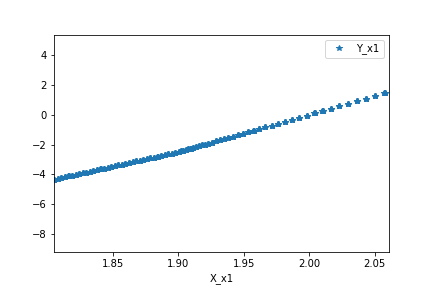

[b'\x01\x00\x00\x00@', b'C\x00\x00\x00A', b'P\xc3\x00\x00B', b'\x00\x00\x00\x00K', b'\x1elI\x00L', b'\xec\xce\xfd\xffM', b'\x00\x00\x00\x00S', b'\x9c\x8a+\x07T', b'-5\xc9\xffU', b'\x0f\x1c\x1c\x00C', b'\x01\x00\x00\x00\x81', b'\x8b\x04\x00\x00A', b'\xde\xdc\x00\x00J', b'\x00\x00\x00\x00L', b'\x00\x00\x00\x00M', b'\xb9\x91\x15\x00R', b'\x00\x00\x00\x00T', b'\x00\x00\x00\x00U', b'\x05\x1e\x1e\x00C', b'\x01\x00\x00\x00\x82', b'\x03\x00\x00\x00\x84', b'\x01\x00\x00\x00\x81', b'4\x00\x00\x00A', b'|\x02\xa1\xffL', b'J\xa7\x03\x00M', b'06\xb9\xf6T', b'\x88V[\x00U', b'\x05\x1c\x1c\x00C', b'\x01\x00\x00\x00\x82', b'\x03\x00\x00\x00\x84', b'\x01\x00\x00\x00\x81', b'\x9f\x01\x00\x00A', b'\xfbH\x00\x00J', b'\x00\x00\x00\x00L', b'\x00\x00\x00\x00M', b'}\x8c\x05\x00R', b'\x00\x00\x00\x00T', b'\x00\x00\x00\x00U', b'\x05\x1e\x1e\x00C', b'\x01\x00\x00\x00\x82', b'\x03\x00\x00\x00\x84', b'\x01\x00\x00\x00\x81', b'\x12\x00\x00\x00A', b'[\xc2\x8f\rL', b'\xbd?~\xfeM', b'W\xd5\xb1\xe5T', b'\xa1=\xec\x02U', 

In [82]:
#steps_opt.plot(x = steps_opt["X_x"]/80, y = steps_opt["Y_x"]/80, style="*")

#steps_opt.plot(x = "ts", y = ["X_a", "Y_a"], style="*")
#steps_opt.plot(x = "ts", y = ["X_x", "Y_x"], style="*")
#steps_opt.plot(x = "ts", y = ["X_x", "Y_x"], style="*")
steps_opt["X_x1"] = steps_opt["X_x"]/80
steps_opt["Y_x1"] = steps_opt["Y_x"]/80

steps_opt.plot(x = "X_x1", y = "Y_x1", style="*")

code = p.asg.gen_path_code(pr_opt)
print(code)
            